# Attention-based Neural Machine Translation

## Introduction
This notebook is a step by step guide on implementation *Attention-based Neural Machine Translation*, and is the solution to coding sections of [Assignment #4](http://web.stanford.edu/class/cs224n/assignments/a4.pdf) of Stanford's ["CS224n: Natural Language Processing with Deep Learning"](http://web.stanford.edu/class/cs224n/) course . Contents of this notebook are taken from the course materials. <br> 
In Machine Translation, our goal is to convert a sentence from the source language (e.g. Spanish) to the target language (e.g. English). In this notebook, we will implement a sequence-to-sequence (Seq2Seq)
network with attention, to build a Neural Machine Translation (NMT) system. To learn about the details of training procedure, check out the assignment PDF file.

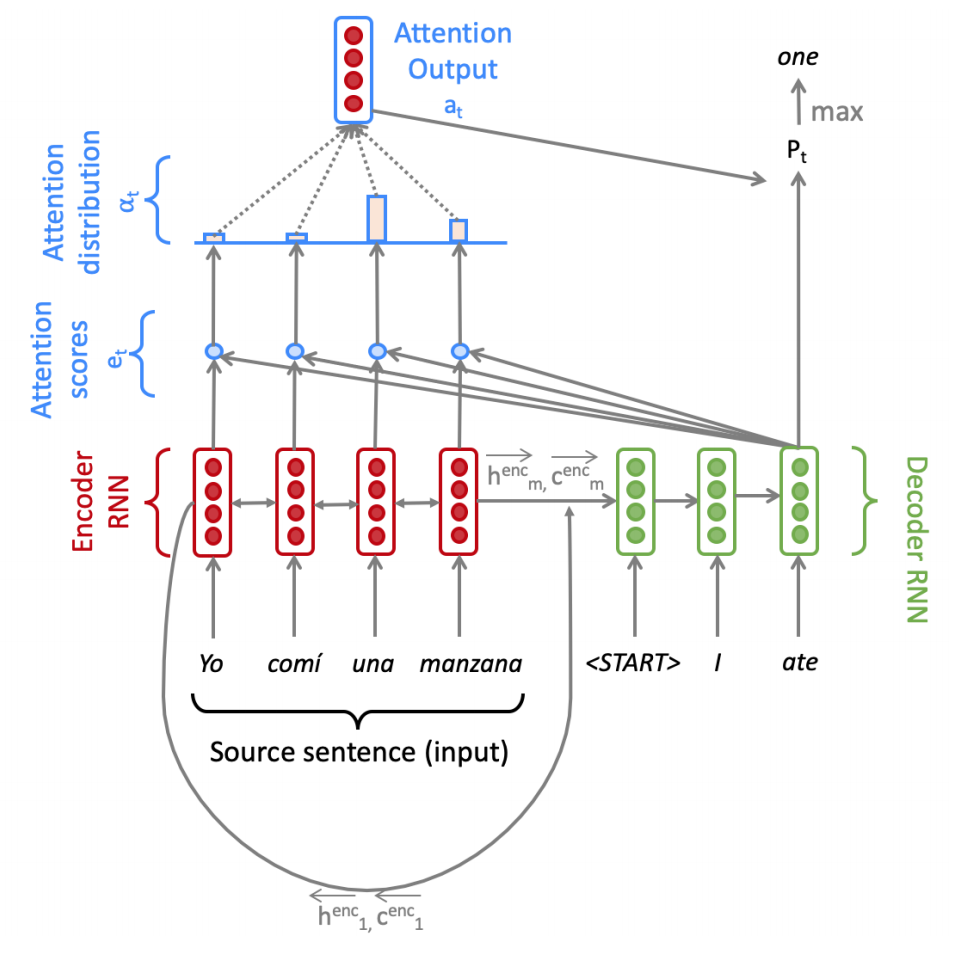

<center> Seq2Seq Model with Multiplicative Attention, shown on the third step of the decoder. Note that
for readability, we do not picture the concatenation of the previous combined-output with the decoder input. <\center>

# Implementation

In [1]:
from collections import namedtuple
import sys
from typing import List, Tuple, Dict, Set, Union
import torch
import torch.nn as nn
import torch.nn.utils
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

Hypothesis = namedtuple('Hypothesis', ['value', 'score'])

 In order to apply tensor operations, we must ensure that the sentences in a given batch
are of the same length. Thus, we must identify the longest sentence in a batch and pad others to
be the same length. We will implement the `pad_sents` function which will produce these
padded sentences.

In [4]:
def pad_sents(sents, pad_token):
    """ Pad list of sentences according to the longest sentence in the batch.
    @param sents (list[list[str]]): list of sentences, where each sentence
                                    is represented as a list of words
    @param pad_token (str): padding token
    @returns sents_padded (list[list[str]]): list of sentences where sentences shorter
        than the max length sentence are padded out with the pad_token, such that
        each sentences in the batch now has equal length.
    """
    sents_padded = []

    len_sents=[len(sentc) for sentc in sents]
    max_len=max(len_sents)
    
    for length,sentc in zip(len_sents,sents):
        padded_sentc=sentc.copy()
        len_pad=max_len-length
        if len_pad>0:
            padded_sentc=padded_sentc + len_pad * [pad_token]
        sents_padded.append(padded_sentc)

    return sents_padded

Next we will define the `ModelEmbeddings` class, which converts input words to their embeddings. Two embedding layers are defined in this class, one for the source language and one for the target language:

In [5]:
class ModelEmbeddings(nn.Module): 
    """
    Class that converts input words to their embeddings.
    """
    def __init__(self, embed_size, vocab):
        """
        Init the Embedding layers.

        @param embed_size (int): Embedding size (dimensionality)
        @param vocab (Vocab): Vocabulary object containing src and tgt languages
                              See vocab.py for documentation.
        """
        super(ModelEmbeddings, self).__init__()
        self.embed_size = embed_size

        self.source = None
        self.target = None

        src_pad_token_idx = vocab.src['<pad>']
        tgt_pad_token_idx = vocab.tgt['<pad>']
        
        self.source=nn.Embedding(len(vocab.src),self.embed_size,src_pad_token_idx)
        self.target=nn.Embedding(len(vocab.tgt),self.embed_size,tgt_pad_token_idx)

Then we are going the implement the `NMT` class, which is the NN that we intend to train. Following methods and properties are included in `NMT`:
- `__init__`: Class constructor, this is where we initialize all the layers in `NMT`,
- `forward` : Performs one pass of feedforward on a minibatch of data,
- `encode` : Applies the "encoder" on source sentences and return encoder hidden states, which will serve as initial state for decoder,
- `decode`: Computes *combined output vectors* for a batch,
- `step`: Compute one forward step of the LSTM decoder, including the attention computation,
- `generate_sent_masks`: Generate sentence masks for encoder hidden states, which contains 1s in positions
corresponding to ‘pad’ tokens in the input, and 0s for non-pad tokens.
- `beam_search`: Given a single source sentence, perform beam search, yielding translations in the target language.
- `device`: Determine which device to place the Tensors upon, CPU or GPU,
- `load` : Loads the model from a file,
- `save`: Saves model to a file.

In [6]:
class NMT(nn.Module):
    """ Simple Neural Machine Translation Model:
        - Bidrectional LSTM Encoder
        - Unidirection LSTM Decoder
        - Global Attention Model (Luong, et al. 2015)
    """
    def __init__(self, embed_size, hidden_size, vocab, dropout_rate=0.2):
        """ Init NMT Model.

        @param embed_size (int): Embedding size (dimensionality)
        @param hidden_size (int): Hidden Size (dimensionality)
        @param vocab (Vocab): Vocabulary object containing src and tgt languages
                              See vocab.py for documentation.
        @param dropout_rate (float): Dropout probability, for attention
        """
        super(NMT, self).__init__()
        self.model_embeddings = ModelEmbeddings(embed_size, vocab)
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        self.vocab = vocab

        # default values
        self.encoder = None 
        self.decoder = None
        self.h_projection = None
        self.c_projection = None
        self.att_projection = None
        self.combined_output_projection = None
        self.target_vocab_projection = None
        self.dropout = None

        self.encoder = nn.LSTM(hidden_size,hidden_size,bidirectional=True,bias=True)
        self.decoder = nn.LSTMCell(embed_size + hidden_size,hidden_size,bias=True)
        self.h_projection = nn.Linear(2*hidden_size,hidden_size,bias=False)
        self.c_projection = nn.Linear(2*hidden_size,hidden_size,bias=False)
        self.att_projection = nn.Linear(2*hidden_size,hidden_size,bias=False)
        self.combined_output_projection = nn.Linear(3*hidden_size,hidden_size,bias=False)
        self.target_vocab_projection = nn.Linear(hidden_size,len(vocab.tgt),bias=False)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, source: List[List[str]], target: List[List[str]]) -> torch.Tensor:
        """ Take a mini-batch of source and target sentences, compute the log-likelihood of
        target sentences under the language models learned by the NMT system.

        @param source (List[List[str]]): list of source sentence tokens
        @param target (List[List[str]]): list of target sentence tokens, wrapped by `<s>` and `</s>`

        @returns scores (Tensor): a variable/tensor of shape (b, ) representing the
                                    log-likelihood of generating the gold-standard target sentence for
                                    each example in the input batch. Here b = batch size.
        """
        # Compute sentence lengths
        source_lengths = [len(s) for s in source]

        # Convert list of lists into tensors

        source_padded = self.vocab.src.to_input_tensor(source, device=self.device)   # Tensor: (src_len, b)
        target_padded = self.vocab.tgt.to_input_tensor(target, device=self.device)   # Tensor: (tgt_len, b)

        enc_hiddens, dec_init_state = self.encode(source_padded, source_lengths)
        enc_masks = self.generate_sent_masks(enc_hiddens, source_lengths)
        combined_outputs = self.decode(enc_hiddens, enc_masks, dec_init_state, target_padded)
        P = F.log_softmax(self.target_vocab_projection(combined_outputs), dim=-1)

        # Zero out, probabilities for which we have nothing in the target text
        target_masks = (target_padded != self.vocab.tgt['<pad>']).float()
        
        # Compute log probability of generating true target words
        target_gold_words_log_prob = torch.gather(P, index=target_padded[1:].unsqueeze(-1), dim=-1).squeeze(-1) * target_masks[1:]
        scores = target_gold_words_log_prob.sum(dim=0)
        return scores


    def encode(self, source_padded: torch.Tensor, source_lengths: List[int]) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """ Apply the encoder to source sentences to obtain encoder hidden states.
            Additionally, take the final states of the encoder and project them to obtain initial states for decoder.

        @param source_padded (Tensor): Tensor of padded source sentences with shape (src_len, b), where
                                        b = batch_size, src_len = maximum source sentence length. Note that 
                                       these have already been sorted in order of longest to shortest sentence.
        @param source_lengths (List[int]): List of actual lengths for each of the source sentences in the batch
        @returns enc_hiddens (Tensor): Tensor of hidden units with shape (b, src_len, h*2), where
                                        b = batch size, src_len = maximum source sentence length, h = hidden size.
        @returns dec_init_state (tuple(Tensor, Tensor)): Tuple of tensors representing the decoder's initial
                                                hidden state and cell.
        """
        enc_hiddens, dec_init_state = None, None
        
        src_len, b = source_padded.shape
        X = self.model_embeddings.source(source_padded)
        X = pack_padded_sequence(X, source_lengths, batch_first=False)
        enc_hiddens, (last_hidden, last_cell)  = self.encoder(X)
        enc_hiddens , output_lens = pad_packed_sequence(enc_hiddens,batch_first=False)
        enc_hiddens = enc_hiddens.permute(1,0,2)
        
        
        h_encoder_0 = torch.cat((last_hidden[0,:,:],last_hidden[1,:,:]),1)
        init_decoder_hidden=self.h_projection(h_encoder_0)
        
        c_encoder_0 = torch.cat((last_cell[0,:,:],last_cell[1,:,:]),1)
        init_decoder_cell=self.h_projection(c_encoder_0)
        
        dec_init_state = (init_decoder_hidden, init_decoder_cell)


        return enc_hiddens, dec_init_state


    def decode(self, enc_hiddens: torch.Tensor, enc_masks: torch.Tensor,
                dec_init_state: Tuple[torch.Tensor, torch.Tensor], target_padded: torch.Tensor) -> torch.Tensor:
        """Compute combined output vectors for a batch.

        @param enc_hiddens (Tensor): Hidden states (b, src_len, h*2), where
                                     b = batch size, src_len = maximum source sentence length, h = hidden size.
        @param enc_masks (Tensor): Tensor of sentence masks (b, src_len), where
                                     b = batch size, src_len = maximum source sentence length.
        @param dec_init_state (tuple(Tensor, Tensor)): Initial state and cell for decoder
        @param target_padded (Tensor): Gold-standard padded target sentences (tgt_len, b), where
                                       tgt_len = maximum target sentence length, b = batch size. 

        @returns combined_outputs (Tensor): combined output tensor  (tgt_len, b,  h), where
                                        tgt_len = maximum target sentence length, b = batch_size,  h = hidden size
        """
        # Chop of the <END> token for max length sentences.
        target_padded = target_padded[:-1]

        # Initialize the decoder state (hidden and cell)
        dec_state = dec_init_state

        # Initialize previous combined output vector o_{t-1} as zero
        batch_size = enc_hiddens.size(0)
        o_prev = torch.zeros(batch_size, self.hidden_size, device=self.device)

        # Initialize a list we will use to collect the combined output o_t on each step
        combined_outputs = []

        enc_hiddens_proj = self.att_projection(enc_hiddens)
        Y = self.model_embeddings.target(target_padded)
        for Y_t in torch.split(Y,1,0):
            Y_t=Y_t.squeeze(0)
            Ybar_t = torch.cat((Y_t,o_prev),1)
            dec_state , o_t , e_t = self.step(Ybar_t,dec_state,enc_hiddens,enc_hiddens_proj,enc_masks)
            combined_outputs.append(o_t)
            o_prev=o_t
        combined_outputs=torch.stack(combined_outputs)
            

        return combined_outputs


    def step(self, Ybar_t: torch.Tensor,
            dec_state: Tuple[torch.Tensor, torch.Tensor],
            enc_hiddens: torch.Tensor,
            enc_hiddens_proj: torch.Tensor,
            enc_masks: torch.Tensor) -> Tuple[Tuple, torch.Tensor, torch.Tensor]:
        """ Compute one forward step of the LSTM decoder, including the attention computation.

        @param Ybar_t (Tensor): Concatenated Tensor of [Y_t o_prev], with shape (b, e + h). The input for the decoder,
                                where b = batch size, e = embedding size, h = hidden size.
        @param dec_state (tuple(Tensor, Tensor)): Tuple of tensors both with shape (b, h), where b = batch size, h = hidden size.
                First tensor is decoder's prev hidden state, second tensor is decoder's prev cell.
        @param enc_hiddens (Tensor): Encoder hidden states Tensor, with shape (b, src_len, h * 2), where b = batch size,
                                    src_len = maximum source length, h = hidden size.
        @param enc_hiddens_proj (Tensor): Encoder hidden states Tensor, projected from (h * 2) to h. Tensor is with shape (b, src_len, h),
                                    where b = batch size, src_len = maximum source length, h = hidden size.
        @param enc_masks (Tensor): Tensor of sentence masks shape (b, src_len),
                                    where b = batch size, src_len is maximum source length. 

        @returns dec_state (tuple (Tensor, Tensor)): Tuple of tensors both shape (b, h), where b = batch size, h = hidden size.
                First tensor is decoder's new hidden state, second tensor is decoder's new cell.
        @returns combined_output (Tensor): Combined output Tensor at timestep t, shape (b, h), where b = batch size, h = hidden size.
        @returns e_t (Tensor): Tensor of shape (b, src_len). It is attention scores distribution.
                                Note: You will not use this outside of this function.
                                      We are simply returning this value so that we can sanity check
                                      your implementation.
        """

        combined_output = None
        dec_state = self.decoder(Ybar_t,dec_state)
        dec_hidden, dec_cell = dec_state[0],dec_state[1]
        e_t = torch.bmm (enc_hiddens_proj,dec_hidden.unsqueeze(2))
        e_t=e_t.squeeze(2)
        ### END YOUR CODE

        # Set e_t to -inf where enc_masks has 1
        if enc_masks is not None:
            e_t.data.masked_fill_(enc_masks.byte(), -float('inf'))
        alpha_t=F.softmax(e_t,1)
        a_t = torch.bmm(alpha_t.unsqueeze(1),enc_hiddens).squeeze(1)
        U_t=torch.cat((dec_hidden,a_t),1)
        V_t=self.combined_output_projection(U_t)
        O_t=torch.tanh(V_t)
        O_t=self.dropout(O_t)

        combined_output = O_t
        return dec_state, combined_output, e_t

    def generate_sent_masks(self, enc_hiddens: torch.Tensor, source_lengths: List[int]) -> torch.Tensor:
        """ Generate sentence masks for encoder hidden states.

        @param enc_hiddens (Tensor): encodings of shape (b, src_len, 2*h), where b = batch size,
                                     src_len = max source length, h = hidden size. 
        @param source_lengths (List[int]): List of actual lengths for each of the sentences in the batch.
        
        @returns enc_masks (Tensor): Tensor of sentence masks of shape (b, src_len),
                                    where src_len = max source length, h = hidden size.
        """
        enc_masks = torch.zeros(enc_hiddens.size(0), enc_hiddens.size(1), dtype=torch.float)
        for e_id, src_len in enumerate(source_lengths):
            enc_masks[e_id, src_len:] = 1
        return enc_masks.to(self.device)


    def beam_search(self, src_sent: List[str], beam_size: int=5, max_decoding_time_step: int=70) -> List[Hypothesis]:
        """ Given a single source sentence, perform beam search, yielding translations in the target language.
        @param src_sent (List[str]): a single source sentence (words)
        @param beam_size (int): beam size
        @param max_decoding_time_step (int): maximum number of time steps to unroll the decoding RNN
        @returns hypotheses (List[Hypothesis]): a list of hypothesis, each hypothesis has two fields:
                value: List[str]: the decoded target sentence, represented as a list of words
                score: float: the log-likelihood of the target sentence
        """
        src_sents_var = self.vocab.src.to_input_tensor([src_sent], self.device)

        src_encodings, dec_init_vec = self.encode(src_sents_var, [len(src_sent)])
        src_encodings_att_linear = self.att_projection(src_encodings)

        h_tm1 = dec_init_vec
        att_tm1 = torch.zeros(1, self.hidden_size, device=self.device)

        eos_id = self.vocab.tgt['</s>']

        hypotheses = [['<s>']]
        hyp_scores = torch.zeros(len(hypotheses), dtype=torch.float, device=self.device)
        completed_hypotheses = []

        t = 0
        while len(completed_hypotheses) < beam_size and t < max_decoding_time_step:
            t += 1
            hyp_num = len(hypotheses)

            exp_src_encodings = src_encodings.expand(hyp_num,
                                                     src_encodings.size(1),
                                                     src_encodings.size(2))

            exp_src_encodings_att_linear = src_encodings_att_linear.expand(hyp_num,
                                                                           src_encodings_att_linear.size(1),
                                                                           src_encodings_att_linear.size(2))

            y_tm1 = torch.tensor([self.vocab.tgt[hyp[-1]] for hyp in hypotheses], dtype=torch.long, device=self.device)
            y_t_embed = self.model_embeddings.target(y_tm1)

            x = torch.cat([y_t_embed, att_tm1], dim=-1)

            (h_t, cell_t), att_t, _  = self.step(x, h_tm1,
                                                      exp_src_encodings, exp_src_encodings_att_linear, enc_masks=None)

            # log probabilities over target words
            log_p_t = F.log_softmax(self.target_vocab_projection(att_t), dim=-1)

            live_hyp_num = beam_size - len(completed_hypotheses)
            contiuating_hyp_scores = (hyp_scores.unsqueeze(1).expand_as(log_p_t) + log_p_t).view(-1)
            top_cand_hyp_scores, top_cand_hyp_pos = torch.topk(contiuating_hyp_scores, k=live_hyp_num)

            prev_hyp_ids = top_cand_hyp_pos / len(self.vocab.tgt)
            hyp_word_ids = top_cand_hyp_pos % len(self.vocab.tgt)

            new_hypotheses = []
            live_hyp_ids = []
            new_hyp_scores = []

            for prev_hyp_id, hyp_word_id, cand_new_hyp_score in zip(prev_hyp_ids, hyp_word_ids, top_cand_hyp_scores):
                prev_hyp_id = prev_hyp_id.item()
                hyp_word_id = hyp_word_id.item()
                cand_new_hyp_score = cand_new_hyp_score.item()

                hyp_word = self.vocab.tgt.id2word[hyp_word_id]
                new_hyp_sent = hypotheses[prev_hyp_id] + [hyp_word]
                if hyp_word == '</s>':
                    completed_hypotheses.append(Hypothesis(value=new_hyp_sent[1:-1],
                                                           score=cand_new_hyp_score))
                else:
                    new_hypotheses.append(new_hyp_sent)
                    live_hyp_ids.append(prev_hyp_id)
                    new_hyp_scores.append(cand_new_hyp_score)

            if len(completed_hypotheses) == beam_size:
                break

            live_hyp_ids = torch.tensor(live_hyp_ids, dtype=torch.long, device=self.device)
            h_tm1 = (h_t[live_hyp_ids], cell_t[live_hyp_ids])
            att_tm1 = att_t[live_hyp_ids]

            hypotheses = new_hypotheses
            hyp_scores = torch.tensor(new_hyp_scores, dtype=torch.float, device=self.device)

        if len(completed_hypotheses) == 0:
            completed_hypotheses.append(Hypothesis(value=hypotheses[0][1:],
                                                   score=hyp_scores[0].item()))

        completed_hypotheses.sort(key=lambda hyp: hyp.score, reverse=True)

        return completed_hypotheses

    @property
    def device(self) -> torch.device:
        """ Determine which device to place the Tensors upon, CPU or GPU.
        """
        return self.model_embeddings.source.weight.device

    @staticmethod
    def load(model_path: str):
        """ Load the model from a file.
        @param model_path (str): path to model
        """
        params = torch.load(model_path, map_location=lambda storage, loc: storage)
        args = params['args']
        model = NMT(vocab=params['vocab'], **args)
        model.load_state_dict(params['state_dict'])

        return model

    def save(self, path: str):
        """ Save the odel to a file.
        @param path (str): path to the model
        """
        print('save model parameters to [%s]' % path, file=sys.stderr)

        params = {
            'args': dict(embed_size=self.model_embeddings.embed_size, hidden_size=self.hidden_size, dropout_rate=self.dropout_rate),
            'vocab': self.vocab,
            'state_dict': self.state_dict()
        }

        torch.save(params, path)


# Training!

In [7]:
from utils import read_corpus, batch_iter
from vocab import Vocab, VocabEntry
import time
import math

Load train and dev sets from corresponding source and target corpus files using `read_corpus` (implemented in `utils`):

In [29]:
train_data_src = read_corpus('./en_es_data/train.es', source='src')
train_data_tgt = read_corpus('./en_es_data/train.en', source='tgt')
dev_data_src = read_corpus('./en_es_data/dev.es', source='src')
dev_data_tgt = read_corpus('./en_es_data/dev.en', source='tgt')
train_data = list(zip(train_data_src, train_data_tgt))
dev_data = list(zip(dev_data_src, dev_data_tgt))

In [30]:
print('There are %d samples (sentences) in the train set.' %(len(train_data_src)))
print('There are %d samples (sentences) in the dev set.' %(len(dev_data_src)))

There are 216617 samples (sentences) in the train set.
There are 851 samples (sentences) in the dev set.


Define the model's hyperparameters, Load `vocab` from vocab file which contains token-to-index look-up tables for source and target languages and initialize the model:

In [31]:
train_batch_size = 32  # batch size
clip_grad = 0.5 # gradient clipping
valid_niter = 2000 #perform validation after how many iterations
log_every = 10 # How often log (save) the model
model_save_path = 'model.bin'

vocab = Vocab.load('vocab.json')

model = NMT(embed_size=256,
            hidden_size=256,
            dropout_rate=0.3,
            vocab=vocab)

model.train()


NMT(
  (model_embeddings): ModelEmbeddings(
    (source): Embedding(50004, 256, padding_idx=0)
    (target): Embedding(50002, 256, padding_idx=0)
  )
  (encoder): LSTM(256, 256, bidirectional=True)
  (decoder): LSTMCell(512, 256)
  (h_projection): Linear(in_features=512, out_features=256, bias=False)
  (c_projection): Linear(in_features=512, out_features=256, bias=False)
  (att_projection): Linear(in_features=512, out_features=256, bias=False)
  (combined_output_projection): Linear(in_features=768, out_features=256, bias=False)
  (target_vocab_projection): Linear(in_features=256, out_features=50002, bias=False)
  (dropout): Dropout(p=0.3)
)

Initialize model parameter using a *Unifrom* distribution ranging [-0.1,0.1]:

In [32]:
for p in model.parameters():
    p.data.uniform_(-0.1, 0.1)

We'll define `evaluate_ppl` to evaluate perplexity on dev set while training:

In [8]:
def evaluate_ppl(model, dev_data, batch_size=32):
    """ Evaluate perplexity on dev sentences
    @param model (NMT): NMT Model
    @param dev_data (list of (src_sent, tgt_sent)): list of tuples containing source and target sentence
    @param batch_size (batch size)
    @returns ppl (perplixity on dev sentences)
    """
    was_training = model.training
    model.eval()

    cum_loss = 0.
    cum_tgt_words = 0.

    # no_grad() signals backend to throw away all gradients
    with torch.no_grad():
        for src_sents, tgt_sents in batch_iter(dev_data, batch_size):
            loss = -model(src_sents, tgt_sents).sum()

            cum_loss += loss.item()
            tgt_word_num_to_predict = sum(len(s[1:]) for s in tgt_sents)  # omitting leading `<s>`
            cum_tgt_words += tgt_word_num_to_predict

        ppl = np.exp(cum_loss / cum_tgt_words)

    if was_training:
        model.train()

    return ppl

Define `vocab_mask` which contains 1s everywhere except the 'pad' token, move the model to `GPU` and define the optimizer (I am using `Adam` optimizer with learning_rate=0.001):

In [ ]:
vocab_mask = torch.ones(len(vocab.tgt))
vocab_mask[vocab.tgt['<pad>']] = 0



if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")


model = model.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

num_trial = 0
train_iter = patience = cum_loss = report_loss = cum_tgt_words = report_tgt_words = 0
cum_examples = report_examples = epoch = valid_num = 0
hist_valid_scores = []

max_epochs=30        ### Maximum number of training epochs
patience_iters = 5   ### wait for how many iterations to decay learning rate
max_num_trial = 5    ### terminate training after how many trials
lr_decay = 0.5       ### lr decay rate

train_time = begin_time = time.time()

## Action time!

In [ ]:
while True:
    epoch += 1

    for src_sents, tgt_sents in batch_iter(train_data, batch_size=train_batch_size, shuffle=True):
        train_iter += 1

        optimizer.zero_grad()

        batch_size = len(src_sents)

        example_losses = -model(src_sents, tgt_sents) # (batch_size,)
        batch_loss = example_losses.sum()
        loss = batch_loss / batch_size

        loss.backward()

        # clip gradient
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

        optimizer.step()

        batch_losses_val = batch_loss.item()
        report_loss += batch_losses_val
        cum_loss += batch_losses_val

        tgt_words_num_to_predict = sum(len(s[1:]) for s in tgt_sents)  # omitting leading `<s>`
        report_tgt_words += tgt_words_num_to_predict
        cum_tgt_words += tgt_words_num_to_predict
        report_examples += batch_size
        cum_examples += batch_size

        if train_iter % log_every == 0:
            print('epoch %d, iter %d, avg. loss %.2f, avg. ppl %.2f ' \
                  'cum. examples %d, speed %.2f words/sec, time elapsed %.2f sec' % (epoch, train_iter,
                                                                                     report_loss / report_examples,
                                                                                     math.exp(report_loss / report_tgt_words),
                                                                                     cum_examples,
                                                                                     report_tgt_words / (time.time() - train_time),
                                                                                     time.time() - begin_time))

            train_time = time.time()
            report_loss = report_tgt_words = report_examples = 0.

        # perform validation
        if train_iter % valid_niter == 0:
            print('epoch %d, iter %d, cum. loss %.2f, cum. ppl %.2f cum. examples %d' % (epoch, train_iter,
                                                                                     cum_loss / cum_examples,
                                                                                     np.exp(cum_loss / cum_tgt_words),
                                                                                     cum_examples))

            cum_loss = cum_examples = cum_tgt_words = 0.
            valid_num += 1

            print('begin validation ...')

            # compute dev. ppl and bleu
            dev_ppl = evaluate_ppl(model, dev_data, batch_size=128)   # dev batch size can be a bit larger
            valid_metric = -dev_ppl

            print('validation: iter %d, dev. ppl %f' % (train_iter, dev_ppl))

            is_better = len(hist_valid_scores) == 0 or valid_metric > max(hist_valid_scores)
            hist_valid_scores.append(valid_metric)

            if is_better:
                patience = 0
                print('save currently the best model to [%s]' % model_save_path)
                model.save(model_save_path)

                # also save the optimizers' state
                torch.save(optimizer.state_dict(), model_save_path + '.optim')
            elif patience < patience_iters:
                patience += 1
                print('hit patience %d' % patience)

                if patience == patience_iters:
                    num_trial += 1
                    print('hit #%d trial' % num_trial)
                    if num_trial == max_num_trial:
                        print('early stop!')
                        exit(0)

                    # decay lr, and restore from previously best checkpoint
                    lr = optimizer.param_groups[0]['lr'] * lr_decay
                    print('load previously best model and decay learning rate to %f' % lr)

                    # load model
                    params = torch.load(model_save_path, map_location=lambda storage, loc: storage)
                    model.load_state_dict(params['state_dict'])
                    model = model.to(device)

                    print('restore parameters of the optimizers')
                    optimizer.load_state_dict(torch.load(model_save_path + '.optim'))

                    # set new lr
                    for param_group in optimizer.param_groups:
                        param_group['lr'] = lr

                    # reset patience
                    patience = 0

            if epoch == max_epochs:
                print('reached maximum number of epochs!')
                break

# Test time!

In [9]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from tqdm import tqdm

First we will define `beam_search` function, which takes a list of sentences in source language and returns list of hypothesis translation for each sentence:

In [10]:
def beam_search(model: NMT, test_data_src: List[List[str]], beam_size: int, max_decoding_time_step: int) -> List[List[Hypothesis]]:
    """ Run beam search to construct hypotheses for a list of src-language sentences.
    @param model (NMT): NMT Model
    @param test_data_src (List[List[str]]): List of sentences (words) in source language, from test set.
    @param beam_size (int): beam_size (# of hypotheses to hold for a translation at every step)
    @param max_decoding_time_step (int): maximum sentence length that Beam search can produce
    @returns hypotheses (List[List[Hypothesis]]): List of Hypothesis translations for every source sentence.
    """
    was_training = model.training
    model.eval()

    hypotheses = []
    with torch.no_grad():
        for src_sent in tqdm(test_data_src, desc='Decoding', file=sys.stdout):
            example_hyps = model.beam_search(src_sent, beam_size=beam_size, max_decoding_time_step=max_decoding_time_step)

            hypotheses.append(example_hyps)

    if was_training: model.train(was_training)

    return hypotheses

Load the test data and trained model and move the model to GPU if available:

In [12]:
test_data_src = read_corpus('./en_es_data/test.es', source='src')
test_data_tgt = read_corpus('./en_es_data/test.en', source='tgt')

model = NMT.load('model.bin')


if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")


model = model.to(device)

Perform *beam search* on test data sentences, we will use beam size of 5 (i.e. 5 hypotheses translations for each sentence):

In [13]:
beam_size=5
max_decoding_time_steps=70 #maximum number of decoding time steps
hypotheses = beam_search(model, test_data_src,
                         beam_size=beam_size,
                         max_decoding_time_step=max_decoding_time_steps)

Decoding: 100%|██████████| 8064/8064 [05:26<00:00, 24.68it/s]


Now let's take a look at one of test sentences and its translations:

In [14]:
i=0
source_sentence = ' '.join(test_data_src[i])
print('Source sentence: \n%s\n' %(source_sentence))
print('5 hypotheses translations:')
for hyp_trans in hypotheses[i]:
    hyp_trans_str=' '.join(hyp_trans.value)
    print(hyp_trans_str)

Source sentence: 
Ustedes saben que lo que yo hago es escribir para los nios, y, de hecho, probablemente soy el autor para nios, ms ledo en los EEUU.

5 hypotheses translations:
You know that what I do is write for kids, and in fact, I'm probably the author for kids, read in the United States.
You know that what I do is write for kids, and in fact, I'm probably the author for kids, read in the U.S.
You know that what I do is write for kids, and in fact, I'm probably the author for children, read in the United States.
You know that what I do is write for children, and in fact, I'm probably the author for kids, read in the United States.
You know that what I do is write for kids, and in fact, I'm probably the author for kids, you read in the United States.


Calculate the **BLEU** score

In [15]:
references=test_data_tgt
top_hypotheses = [hyps[0] for hyps in hypotheses]


if references[0][0] == '<s>':
        references = [ref[1:-1] for ref in references]
bleu_score=corpus_bleu([[ref] for ref in references],
                             [hyp.value for hyp in top_hypotheses])
print('BLEU score on test data is %f' %(bleu_score))

BLEU score on test data is 0.226653
